# Holt-Winters Exponential Smoothing
The following concepts are covered:  
1. EDA  
2. Forecasting with a naive model  
3. Forecasting with variants of the HWES model  
4. Model comparisons  
5. Results Visualizations  

- the model's documentation from statsmodels: https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import seaborn as sns
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from scalecast.Forecaster import Forecaster

Download data from FRED (https://fred.stlouisfed.org/series/HOUSTNSA). This data is interesting due to its strong seasonality and irregular cycles. It measures monthly housing starts in the USA since 1959. Since exponential smoothing generally doesn't need as much data to work effectively, we start the series in 2010, where it has a clear trend and seasonality.

In [2]:
df = pdr.get_data_fred('HOUSTNSA',start='2010-01-01',end='2021-12-31')
f = Forecaster(y=df['HOUSTNSA'],current_dates=df.index)
f

Forecaster(
    DateStartActuals=2010-01-01T00:00:00.000000000
    DateEndActuals=2021-12-01T00:00:00.000000000
    Freq=MS
    N_actuals=144
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
    GridsFile=Grids
)

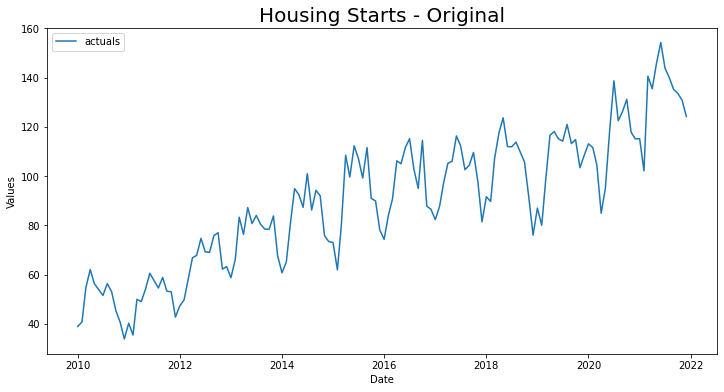

In [3]:
f.plot()
plt.title('Housing Starts - Original',size=20)
plt.show()

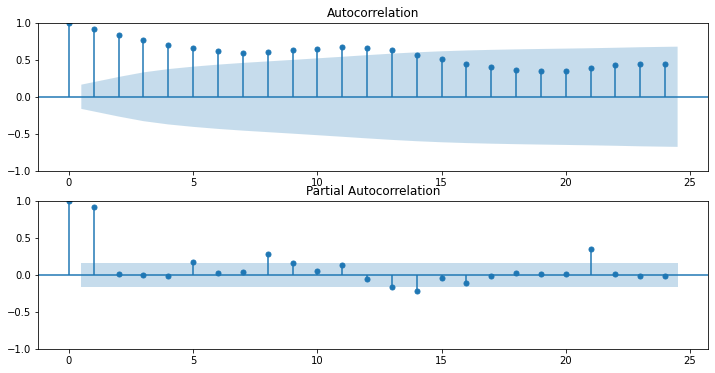

In [27]:
figs, axs = plt.subplots(2, 1,figsize=(12,6))
f.plot_acf(ax=axs[0],lags=24)
f.plot_pacf(ax=axs[1],lags=24)
plt.show()

Exponential smoothing takes the series' past into consideration when making forecasts to the future. It uses a weighted average of the past values to form a theory about the future.

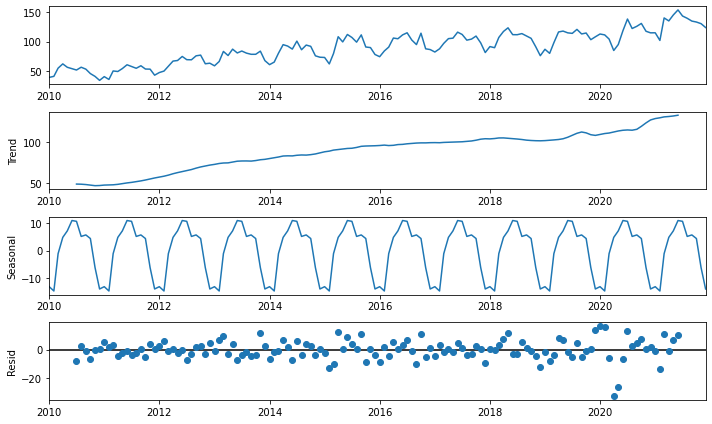

In [5]:
plt.rc("figure",figsize=(10,6))
f.seasonal_decompose().plot()
plt.show()

We see a clear trend and seasonality. Holt-Winters Exponential Smoothing extends normal ES techniques by allowing the trend and seasonality to also be modeled. The residuals look fairly random, meaning an additive application of the model may be most appriopriate, although we will apply both additive and multiplicative.

In [6]:
critical_pval = 0.05
print('-'*100)
print('Augmented Dickey-Fuller results:')
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print('the test-stat value is: {:.2f}'.format(stat))
print('the p-value is {:.4f}'.format(pval))
print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
print('-'*100)

----------------------------------------------------------------------------------------------------
Augmented Dickey-Fuller results:
the test-stat value is: -0.15
the p-value is 0.9444
the series is not stationary
----------------------------------------------------------------------------------------------------


HWES does not require the series to be stationary.

## Prepare Forecast
- Set forecast horizon: 24 periods (2 years)
- Test Length: 20%
- Validation length for tuning models: 12 periods
- Other regressors not needed as all model compenents are specified when calling the forecast functions

In [7]:
f.generate_future_dates(24)
f.set_test_length(.2)
f.set_validation_length(12)
f

Forecaster(
    DateStartActuals=2010-01-01T00:00:00.000000000
    DateEndActuals=2021-12-01T00:00:00.000000000
    Freq=MS
    N_actuals=144
    ForecastLength=24
    Xvars=[]
    Differenced=0
    TestLength=28
    ValidationLength=12
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
    GridsFile=Grids
)

## Forecast

### Naive

In [8]:
f.set_estimator('hwes')

In [9]:
f.manual_forecast(call_me='naive')

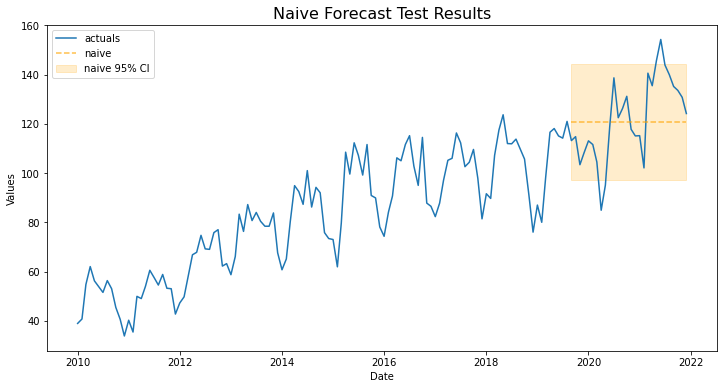

In [10]:
f.plot_test_set(ci=True)
plt.title('Naive Forecast Test Results',size=16)
plt.show()

This model, which is the default, took the last observed value and propogated it forward.

### Trend Only

- let's see what the model looks like when we factor in the series' trend

In [11]:
f.manual_forecast(trend='add',call_me='trend')

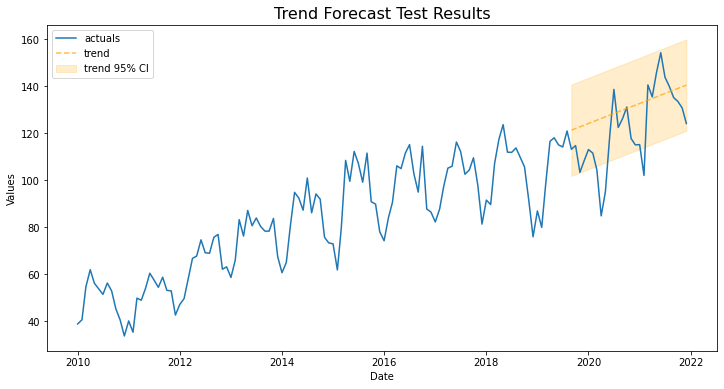

In [12]:
f.plot_test_set(ci=True,models='trend')
plt.title('Trend Forecast Test Results',size=16)
plt.show()

This forecast is more dynamic, but not even close to the series' actual patterns.

### Trend + Seasonality

In [13]:
f.manual_forecast(trend='add',seasonal='add',call_me='add')

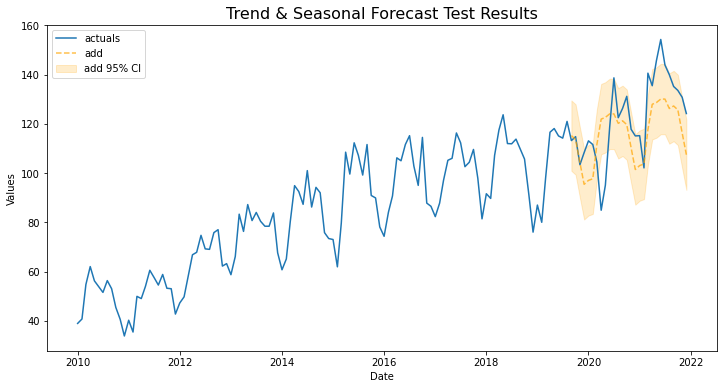

In [14]:
f.plot_test_set(ci=True,models='add')
plt.title('Trend & Seasonal Forecast Test Results',size=16)
plt.show()

This already looks much better, but it's not quite capturing the series' full pattern.

### Multiplicative Model

In [15]:
f.manual_forecast(trend='mul',seasonal='mul',call_me='mul')

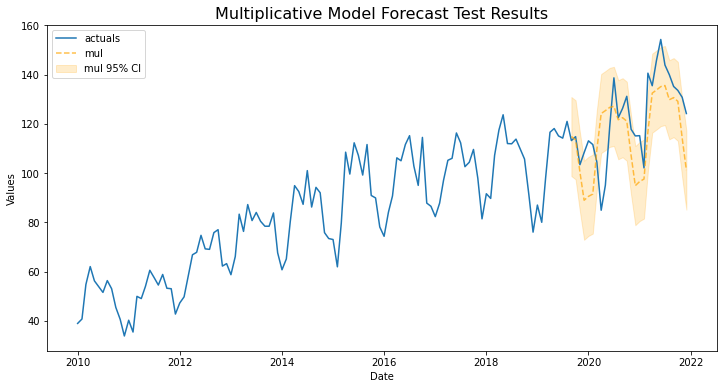

In [16]:
f.plot_test_set(ci=True,models='mul')
plt.title('Multiplicative Model Forecast Test Results',size=16)
plt.show()

This looks like it got a little closer, but let's see if we can do even better.

### Tuned Model

In [20]:
grid = {
    'trend':['add','mul'],
    'seasonal':['add','mul'],
    'damped_trend':[True,False],
    'use_boxcox':[True,False],
    'initialization_method':[None,'estimated','heuristic']
}

f.ingest_grid(grid)
f.tune()
f.auto_forecast(call_me='tuned')

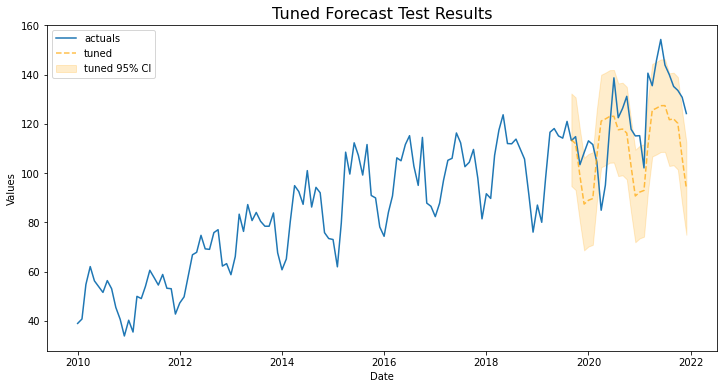

In [21]:
f.plot_test_set(ci=True,models='tuned')
plt.title('Tuned Forecast Test Results',size=16)
plt.show()

In [22]:
f.export_validation_grid('tuned').sort_values('metric_value').head(5)

,trend,seasonal,damped_trend,use_boxcox,initialization_method,validation_length,validation_metric,metric_value
17,add,mul,True,False,heuristic,12,rmse,8.409091
16,add,mul,True,False,estimated,12,rmse,8.409091
15,add,mul,True,False,None,12,rmse,8.409322
13,add,mul,True,True,estimated,12,rmse,8.422685
14,add,mul,True,True,heuristic,12,rmse,8.422685


The best model on the 12 validation periods (which were tested out-of-sample from a model trained on all previous periods) had the additive trend, multiplicative seasonality, and damped trend.

## Compare Results

### Model Summaries
- now we see which model was actually best

In [23]:
pd.set_option('display.float_format',  '{:.4f}'.format)
ms = f.export('model_summaries',determine_best_by='TestSetRMSE')
ms[
    [
        'ModelNickname',
        'TestSetMAPE',
        'TestSetR2',
        'InSampleMAPE',
        'InSampleR2',
        'models',
        'best_model'
    ]
]

,ModelNickname,TestSetMAPE,TestSetR2,InSampleMAPE,InSampleR2,models,best_model
0,add,0.1024,0.1897,0.0623,0.9238,None,True
1,mul,0.1102,0.0522,0.0671,0.9183,None,False
2,trend,0.1153,0.0494,0.0932,0.8615,None,False
3,naive,0.1153,-0.0087,0.0922,0.8609,None,False
4,tuned,0.1384,-0.3575,0.0673,0.9188,None,False


On our 28-period test set, the additive model was the best and the tuned model was the worst, even worse than the naive model. The tuned model did well on the 12 periods before the 28-period test set, but didn't do well after, possibly because it used a damped trend at a time when housing starts exploded. That's the danger of tuning models and sometimes it is good to only tune parameters you think follow common sense. For instance, the damped trend probably should not have been tuned at all in that process, given what we know about the current housing market.

### Fitted Values

- Order all models by test MAPE values

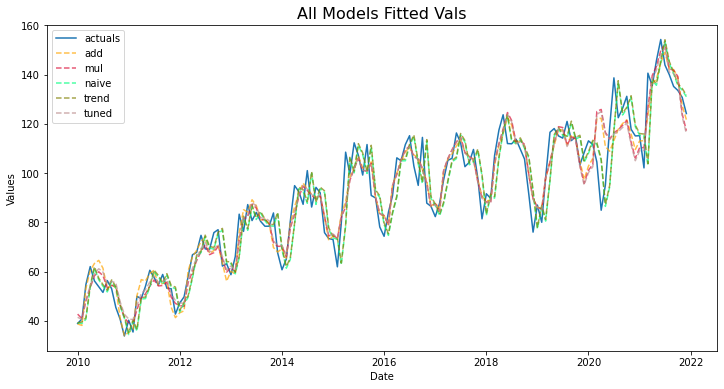

In [24]:
f.plot_fitted(order_by='TestSetMAPE')
plt.title('All Models Fitted Vals',size=16)
plt.show()

### Final Forecasts

- Top-2 by test MAPE values

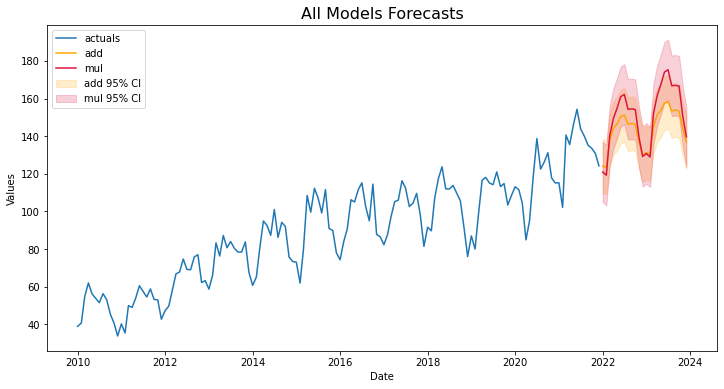

In [25]:
f.plot(ci=True,models='top_2',order_by='TestSetMAPE')
plt.title('All Models Forecasts',size=16)
plt.show()

### Model Summaries

To see the model summary of the last model run, you can use this code:

In [26]:
f.regr.summary()

Dep. Variable:,HOUSTNSA,No. Observations:,144
Model:,ExponentialSmoothing,SSE,8697.764
Optimized:,True,AIC,624.545
Trend:,Additive,BIC,675.032
Seasonal:,Multiplicative,AICC,630.674
Seasonal Periods:,12,Date:,"Tue, 25 Oct 2022"
Box-Cox:,False,Time:,13:43:44
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3154839,alpha,True
smoothing_trend,2.3825e-08,beta,True
